In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
data = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=nly&outputsize=full&apikey=9HXBL1MHLXSUW3XP')
data = data.json()

In [3]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'nly',
 '3. Last Refreshed': '2020-01-16 13:11:52',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [4]:
df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient = 'index')

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df.columns = ['open', 'high', 'low', 'close', 'volume']
for i in df.columns:
    df[[f'{i}']] = df[[f'{i}']].apply(pd.to_numeric)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2020-01-16 to 2000-01-14
Data columns (total 5 columns):
open      5033 non-null float64
high      5033 non-null float64
low       5033 non-null float64
close     5033 non-null float64
volume    5033 non-null int64
dtypes: float64(4), int64(1)
memory usage: 235.9 KB


In [8]:
df.tail()

,open,high,low,close,volume
2000-01-21,8.375,8.375,8.250,8.250,19000
2000-01-20,8.375,8.375,8.313,8.313,24000
2000-01-19,8.313,8.375,8.250,8.313,17700
2000-01-18,8.500,8.500,8.313,8.313,18100
2000-01-14,8.438,8.625,8.313,8.375,31600


In [9]:
#df['daily_change'] = df['close'] - df['open']

In [10]:
df.drop(['high','low', 'open', 'volume'], axis=1, inplace = True)

In [11]:
df

,close
2020-01-16,9.635
2020-01-15,9.620
2020-01-14,9.600
2020-01-13,9.570
2020-01-10,9.540
...,...
2000-01-21,8.250
2000-01-20,8.313
2000-01-19,8.313
2000-01-18,8.313


In [12]:
#df[["close"]] = df[["close"]].apply(pd.to_numeric)

In [13]:
df_full = df


In [14]:
stan_dev_cutoff = df.std().sum() * 2.5
low_cutoff = df.mean().sum() - stan_dev_cutoff 
high_cutoff = df.mean().sum() + stan_dev_cutoff

print(low_cutoff, high_cutoff)
print(df.loc[df['close'] > high_cutoff])
print(df.loc[df['close'] < low_cutoff])
#df.drop(index =['2017-06-26', '2017-06-23'])

5.308938019593139 22.642212944046666
Empty DataFrame
Columns: [close]
Index: []
Empty DataFrame
Columns: [close]
Index: []


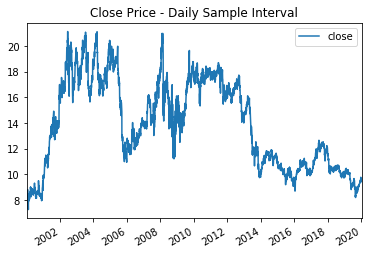

In [15]:
df.plot(title= 'Close Price - Daily Sample Interval');

In [16]:
dfm = df.resample('m').mean()
dfm_full = df_full.resample('m').mean()

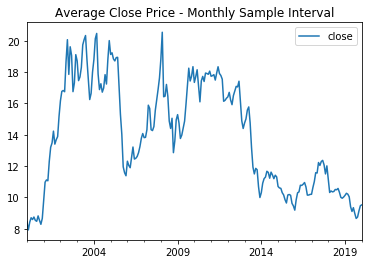

In [17]:
dfm.plot(title='Average Close Price - Monthly Sample Interval');

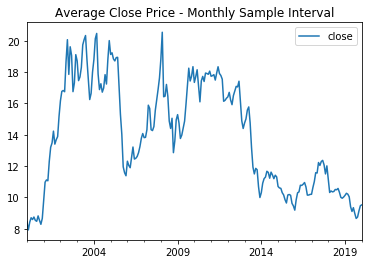

In [18]:
dfm_full.plot(title='Average Close Price - Monthly Sample Interval');

In [19]:
# Dickey fuller - for stationarity
## had to take difference to decrease the DF below the 5% critical value
dfmd = dfm.diff().dropna()

from statsmodels.tsa.stattools import adfuller
dickyf = adfuller(dfmd['close'])
dickyf

(-8.0075435509394,
 2.246537163627505e-12,
 3,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 533.8524848882764)

<Figure size 2160x720 with 0 Axes>

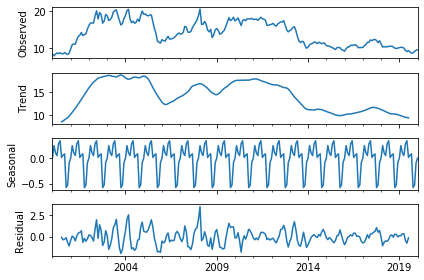

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dfm, freq=12)
fig = plt.figure(figsize = (30,10))
fig = decomposition.plot();


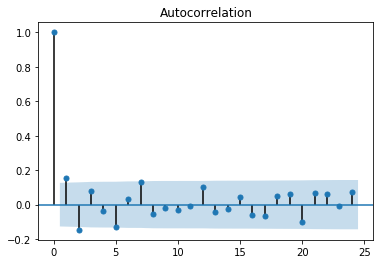

In [21]:
# auto correlation function
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(dfmd['close']);

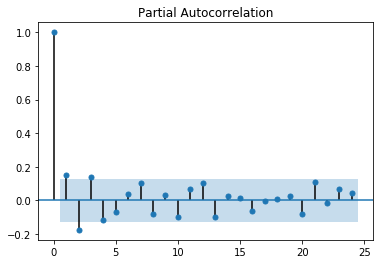

In [22]:
### partial auto correlation function
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dfmd['close']);

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
from statsmodels.tsa.statespace import sarimax


model = sarimax.SARIMAX(dfm['close'], 
                        order=(0,1,2), 
                        seasonal_order = (1,1,2,12), 
                        enforce_stationarity=False,
                        enforce_invertibility=False)
res = model.fit()
res.summary()
#red = res.get_prediction()

#ARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC Calculated =33.907072774811255
## or ARIMA (1, 1, 0) x (0, 1, 1, 3) : AIC Calculated =39.92117593191608

#new
# ARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC Calculated =32.549985654704024
#ARIMA (0, 1, 0) x (0, 1, 1, 3) : AIC Calculated =38.562085400883134
#ARIMA (1, 1, 0) x (0, 1, 1, 3) : AIC Calculated =39.307049385566245

# New new
# ARIMA (0, 1, 0) x (1, 1, 1, 12) : AIC Calculated =34.76943087669308

#IDK - looking at df not dfm
#ARIMA (0, 1, 0) x (0, 1, 0, 12) : AIC Calculated =-1022.3211094034486


#Change window of dates 2015->2016
#ARIMA (0, 1, 0) x (0, 1, 1, 3) : AIC Calculated =30.425769716940614
#ARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC Calculated =0.6043184089089753
#ARIMA (0, 1, 2) x (1, 1, 0, 12) : AIC Calculated =0.5000707205748007

#consider all the data
#ARIMA (0, 1, 2) x (1, 1, 2, 12) : AIC Calculated =475.66551743655816


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  241
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -231.832
Date:                            Thu, 16 Jan 2020   AIC                            475.663
Time:                                    12:12:01   BIC                            495.483
Sample:                                01-31-2000   HQIC                           483.683
                                     - 01-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2565      0.061      4.221      0.000       0.137       0.376
ma.L2         -0.0826      0.075     -1.101      0.271      -0.230       0.064
ar.S.L12      -0.8108      0.057    -14.208      0.000      -0.923      -0.699
ma.S.L12      -0.1027    384.706     -0.000      1.000    -754.113     753.908
ma.S.L24      -1.1028    424.215     -0.003      0.998    -832.549     830.344
sigma2         0.4104    157.876      0.003      0.998    -309.021     309.842
===================================================================================
Ljung-Box (Q):                       42.40   Jarque-Bera (JB):               229.78
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
type(res)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

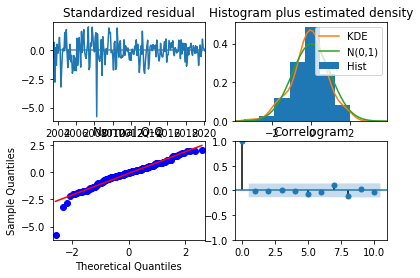

In [26]:
res.plot_diagnostics();

In [27]:
import itertools

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(1,3)
s = 3

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p,d,q))]

In [29]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sarimax.SARIMAX(dfm['close'],
                                  order=comb,
                                  seasonal_order=combs,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue
        print(f'ARIMA {comb} x {combs} : AIC Calculated ={output.aic}')

ARIMA (0, 1, 0) x (0, 1, 0, 3) : AIC Calculated =713.6762887244745
ARIMA (0, 1, 0) x (0, 1, 1, 3) : AIC Calculated =568.4870592912587
ARIMA (0, 1, 0) x (0, 1, 2, 3) : AIC Calculated =564.9795664538453
ARIMA (0, 1, 0) x (0, 2, 0, 3) : AIC Calculated =959.1521752105971
ARIMA (0, 1, 0) x (0, 2, 1, 3) : AIC Calculated =713.9233383984159
ARIMA (0, 1, 0) x (0, 2, 2, 3) : AIC Calculated =579.2861760257272
ARIMA (0, 1, 0) x (1, 1, 0, 3) : AIC Calculated =651.4904688755644
ARIMA (0, 1, 0) x (1, 1, 1, 3) : AIC Calculated =571.0202668039052
ARIMA (0, 1, 0) x (1, 1, 2, 3) : AIC Calculated =566.8509969888547
ARIMA (0, 1, 0) x (1, 2, 0, 3) : AIC Calculated =821.5434397457998
ARIMA (0, 1, 0) x (1, 2, 1, 3) : AIC Calculated =658.6709138891081
ARIMA (0, 1, 0) x (1, 2, 2, 3) : AIC Calculated =583.2363024066636
ARIMA (0, 1, 0) x (2, 1, 0, 3) : AIC Calculated =627.9439351565547
ARIMA (0, 1, 0) x (2, 1, 1, 3) : AIC Calculated =568.860422301034
ARIMA (0, 1, 0) x (2, 1, 2, 3) : AIC Calculated =561.4310215263

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 3) : AIC Calculated =568.9984964633687
ARIMA (0, 2, 0) x (0, 1, 0, 3) : AIC Calculated =801.6653924000746
ARIMA (0, 2, 0) x (0, 1, 1, 3) : AIC Calculated =681.2180544468908
ARIMA (0, 2, 0) x (0, 1, 2, 3) : AIC Calculated =671.5111743710934
ARIMA (0, 2, 0) x (0, 2, 0, 3) : AIC Calculated =1032.301653654281
ARIMA (0, 2, 0) x (0, 2, 1, 3) : AIC Calculated =799.6340674766175
ARIMA (0, 2, 0) x (0, 2, 2, 3) : AIC Calculated =689.6478372684746
ARIMA (0, 2, 0) x (1, 1, 0, 3) : AIC Calculated =758.7806720166168
ARIMA (0, 2, 0) x (1, 1, 1, 3) : AIC Calculated =679.5013012488595
ARIMA (0, 2, 0) x (1, 1, 2, 3) : AIC Calculated =673.3660387479936
ARIMA (0, 2, 0) x (1, 2, 0, 3) : AIC Calculated =921.9131404851546
ARIMA (0, 2, 0) x (1, 2, 1, 3) : AIC Calculated =764.0824796421164
ARIMA (0, 2, 0) x (1, 2, 2, 3) : AIC Calculated =688.6232708574977
ARIMA (0, 2, 0) x (2, 1, 0, 3) : AIC Calculated =731.59593402676
ARIMA (0, 2, 0) x (2, 1, 1, 3) : AIC Calculated =677.35573440999

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 3) : AIC Calculated =581.9212193396639
ARIMA (1, 1, 0) x (0, 1, 0, 3) : AIC Calculated =698.3717773762914
ARIMA (1, 1, 0) x (0, 1, 1, 3) : AIC Calculated =562.4923419302306
ARIMA (1, 1, 0) x (0, 1, 2, 3) : AIC Calculated =558.4285300611127
ARIMA (1, 1, 0) x (0, 2, 0, 3) : AIC Calculated =938.4010821716033
ARIMA (1, 1, 0) x (0, 2, 1, 3) : AIC Calculated =699.3338012538776
ARIMA (1, 1, 0) x (0, 2, 2, 3) : AIC Calculated =573.6987297215104
ARIMA (1, 1, 0) x (1, 1, 0, 3) : AIC Calculated =642.4015813864455
ARIMA (1, 1, 0) x (1, 1, 1, 3) : AIC Calculated =564.3429158373516
ARIMA (1, 1, 0) x (1, 1, 2, 3) : AIC Calculated =560.3662777244427
ARIMA (1, 1, 0) x (1, 2, 0, 3) : AIC Calculated =810.0059068173869
ARIMA (1, 1, 0) x (1, 2, 1, 3) : AIC Calculated =651.5235601627767
ARIMA (1, 1, 0) x (1, 2, 2, 3) : AIC Calculated =575.6984771114123
ARIMA (1, 1, 0) x (2, 1, 0, 3) : AIC Calculated =618.658666883219
ARIMA (1, 1, 0) x (2, 1, 1, 3) : AIC Calculated =561.8987888128

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 3) : AIC Calculated =566.0933570909076
ARIMA (1, 1, 1) x (2, 1, 0, 3) : AIC Calculated =613.6850073858153
ARIMA (1, 1, 1) x (2, 1, 1, 3) : AIC Calculated =553.65370779965
ARIMA (1, 1, 1) x (2, 1, 2, 3) : AIC Calculated =548.7252274712549
ARIMA (1, 1, 1) x (2, 2, 0, 3) : AIC Calculated =754.539636593092
ARIMA (1, 1, 1) x (2, 2, 1, 3) : AIC Calculated =621.5807095211629


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 3) : AIC Calculated =568.0866474261304
ARIMA (1, 1, 2) x (0, 1, 0, 3) : AIC Calculated =647.9769830717682
ARIMA (1, 1, 2) x (0, 1, 1, 3) : AIC Calculated =553.2760854800999
ARIMA (1, 1, 2) x (0, 1, 2, 3) : AIC Calculated =548.6600808833678
ARIMA (1, 1, 2) x (0, 2, 0, 3) : AIC Calculated =867.0545654018315
ARIMA (1, 1, 2) x (0, 2, 1, 3) : AIC Calculated =652.4087851616575


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (0, 2, 2, 3) : AIC Calculated =563.4818902315537
ARIMA (1, 1, 2) x (1, 1, 0, 3) : AIC Calculated =614.2048100912236
ARIMA (1, 1, 2) x (1, 1, 1, 3) : AIC Calculated =555.2719852860121
ARIMA (1, 1, 2) x (1, 1, 2, 3) : AIC Calculated =550.4413987542009
ARIMA (1, 1, 2) x (1, 2, 0, 3) : AIC Calculated =764.4248936254094
ARIMA (1, 1, 2) x (1, 2, 1, 3) : AIC Calculated =622.5233288452162


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 3) : AIC Calculated =567.8620395852026
ARIMA (1, 1, 2) x (2, 1, 0, 3) : AIC Calculated =594.765078914401
ARIMA (1, 1, 2) x (2, 1, 1, 3) : AIC Calculated =556.0394532144007
ARIMA (1, 1, 2) x (2, 1, 2, 3) : AIC Calculated =546.7125652849971
ARIMA (1, 1, 2) x (2, 2, 0, 3) : AIC Calculated =715.1468730309812
ARIMA (1, 1, 2) x (2, 2, 1, 3) : AIC Calculated =609.4940597283601


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 3) : AIC Calculated =574.6035450370882
ARIMA (1, 2, 0) x (0, 1, 0, 3) : AIC Calculated =793.939941398151
ARIMA (1, 2, 0) x (0, 1, 1, 3) : AIC Calculated =659.881353667801
ARIMA (1, 2, 0) x (0, 1, 2, 3) : AIC Calculated =654.0601686762789
ARIMA (1, 2, 0) x (0, 2, 0, 3) : AIC Calculated =1029.7439900863517
ARIMA (1, 2, 0) x (0, 2, 1, 3) : AIC Calculated =792.1573635860378
ARIMA (1, 2, 0) x (0, 2, 2, 3) : AIC Calculated =668.7634924514161
ARIMA (1, 2, 0) x (1, 1, 0, 3) : AIC Calculated =738.2560116547538
ARIMA (1, 2, 0) x (1, 1, 1, 3) : AIC Calculated =661.456448997785
ARIMA (1, 2, 0) x (1, 1, 2, 3) : AIC Calculated =656.3082720488205
ARIMA (1, 2, 0) x (1, 2, 0, 3) : AIC Calculated =900.5331361404734
ARIMA (1, 2, 0) x (1, 2, 1, 3) : AIC Calculated =746.0996184521091
ARIMA (1, 2, 0) x (1, 2, 2, 3) : AIC Calculated =669.8451710575599
ARIMA (1, 2, 0) x (2, 1, 0, 3) : AIC Calculated =716.2992517414632
ARIMA (1, 2, 0) x (2, 1, 1, 3) : AIC Calculated =656.56239672423

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 3) : AIC Calculated =672.4098097111732
ARIMA (1, 2, 1) x (0, 1, 0, 3) : AIC Calculated =701.1681877212537
ARIMA (1, 2, 1) x (0, 1, 1, 3) : AIC Calculated =569.8287695730316
ARIMA (1, 2, 1) x (0, 1, 2, 3) : AIC Calculated =564.2116957172534
ARIMA (1, 2, 1) x (0, 2, 0, 3) : AIC Calculated =938.3549088263544
ARIMA (1, 2, 1) x (0, 2, 1, 3) : AIC Calculated =791.1162684754972
ARIMA (1, 2, 1) x (0, 2, 2, 3) : AIC Calculated =583.6913400609399
ARIMA (1, 2, 1) x (1, 1, 0, 3) : AIC Calculated =647.2475976763593
ARIMA (1, 2, 1) x (1, 1, 1, 3) : AIC Calculated =571.8283444651754
ARIMA (1, 2, 1) x (1, 1, 2, 3) : AIC Calculated =565.9048042976216
ARIMA (1, 2, 1) x (1, 2, 0, 3) : AIC Calculated =813.9839247519151
ARIMA (1, 2, 1) x (1, 2, 1, 3) : AIC Calculated =658.5267009604771
ARIMA (1, 2, 1) x (1, 2, 2, 3) : AIC Calculated =586.787420880593
ARIMA (1, 2, 1) x (2, 1, 0, 3) : AIC Calculated =623.5230202441669
ARIMA (1, 2, 1) x (2, 1, 1, 3) : AIC Calculated =569.9508478569

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 3) : AIC Calculated =578.741305449028
ARIMA (1, 2, 2) x (2, 1, 0, 3) : AIC Calculated =618.5226516991389


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 3) : AIC Calculated =562.1305139024033


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 3) : AIC Calculated =558.4002474321221
ARIMA (1, 2, 2) x (2, 2, 0, 3) : AIC Calculated =758.9894141361468
ARIMA (1, 2, 2) x (2, 2, 1, 3) : AIC Calculated =632.9363354218938


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 3) : AIC Calculated =578.0294011731318
ARIMA (2, 1, 0) x (0, 1, 0, 3) : AIC Calculated =681.5671947883784
ARIMA (2, 1, 0) x (0, 1, 1, 3) : AIC Calculated =557.7651095685401
ARIMA (2, 1, 0) x (0, 1, 2, 3) : AIC Calculated =552.3397804872902
ARIMA (2, 1, 0) x (0, 2, 0, 3) : AIC Calculated =912.3851250743563
ARIMA (2, 1, 0) x (0, 2, 1, 3) : AIC Calculated =685.7923283253949
ARIMA (2, 1, 0) x (0, 2, 2, 3) : AIC Calculated =569.6234904284787
ARIMA (2, 1, 0) x (1, 1, 0, 3) : AIC Calculated =635.1145111996952
ARIMA (2, 1, 0) x (1, 1, 1, 3) : AIC Calculated =557.737240508643
ARIMA (2, 1, 0) x (1, 1, 2, 3) : AIC Calculated =554.5102002752622
ARIMA (2, 1, 0) x (1, 2, 0, 3) : AIC Calculated =803.2967421962844
ARIMA (2, 1, 0) x (1, 2, 1, 3) : AIC Calculated =644.0523214461946
ARIMA (2, 1, 0) x (1, 2, 2, 3) : AIC Calculated =572.0140151634478
ARIMA (2, 1, 0) x (2, 1, 0, 3) : AIC Calculated =606.3899761516279
ARIMA (2, 1, 0) x (2, 1, 1, 3) : AIC Calculated =554.1355324648

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (0, 1, 1, 3) : AIC Calculated =558.9110281627549
ARIMA (2, 1, 1) x (0, 1, 2, 3) : AIC Calculated =551.3221708659892
ARIMA (2, 1, 1) x (0, 2, 0, 3) : AIC Calculated =800.1771582900158
ARIMA (2, 1, 1) x (0, 2, 1, 3) : AIC Calculated =634.573665668422


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (0, 2, 2, 3) : AIC Calculated =572.4258143754458
ARIMA (2, 1, 1) x (1, 1, 0, 3) : AIC Calculated =608.9828520663866
ARIMA (2, 1, 1) x (1, 1, 1, 3) : AIC Calculated =559.1849473761808
ARIMA (2, 1, 1) x (1, 1, 2, 3) : AIC Calculated =553.4399311448062
ARIMA (2, 1, 1) x (1, 2, 0, 3) : AIC Calculated =740.3376331022387
ARIMA (2, 1, 1) x (1, 2, 1, 3) : AIC Calculated =623.2773412381375
ARIMA (2, 1, 1) x (1, 2, 2, 3) : AIC Calculated =572.3045969081235
ARIMA (2, 1, 1) x (2, 1, 0, 3) : AIC Calculated =594.3450293250642
ARIMA (2, 1, 1) x (2, 1, 1, 3) : AIC Calculated =554.8519191105023


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 3) : AIC Calculated =550.3535841236053
ARIMA (2, 1, 1) x (2, 2, 0, 3) : AIC Calculated =698.245592939515
ARIMA (2, 1, 1) x (2, 2, 1, 3) : AIC Calculated =606.9496124010371


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 3) : AIC Calculated =574.9384102846947
ARIMA (2, 1, 2) x (0, 1, 0, 3) : AIC Calculated =628.3513084307602
ARIMA (2, 1, 2) x (0, 1, 1, 3) : AIC Calculated =555.0597403581141
ARIMA (2, 1, 2) x (0, 1, 2, 3) : AIC Calculated =548.8464539112505
ARIMA (2, 1, 2) x (0, 2, 0, 3) : AIC Calculated =788.816249151258
ARIMA (2, 1, 2) x (0, 2, 1, 3) : AIC Calculated =632.8112730034645


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 3) : AIC Calculated =565.4206999649734
ARIMA (2, 1, 2) x (1, 1, 0, 3) : AIC Calculated =610.7791777537087
ARIMA (2, 1, 2) x (1, 1, 1, 3) : AIC Calculated =557.2692049935226
ARIMA (2, 1, 2) x (1, 1, 2, 3) : AIC Calculated =550.4206153418188
ARIMA (2, 1, 2) x (1, 2, 0, 3) : AIC Calculated =736.8294335244547
ARIMA (2, 1, 2) x (1, 2, 1, 3) : AIC Calculated =620.3965586271304


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 3) : AIC Calculated =569.7460701781159
ARIMA (2, 1, 2) x (2, 1, 0, 3) : AIC Calculated =599.7875718281823
ARIMA (2, 1, 2) x (2, 1, 1, 3) : AIC Calculated =556.2009111334679
ARIMA (2, 1, 2) x (2, 1, 2, 3) : AIC Calculated =548.5134065671045
ARIMA (2, 1, 2) x (2, 2, 0, 3) : AIC Calculated =700.1602022337997
ARIMA (2, 1, 2) x (2, 2, 1, 3) : AIC Calculated =609.3071365397311


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 3) : AIC Calculated =572.9865519467388
ARIMA (2, 2, 0) x (0, 1, 0, 3) : AIC Calculated =788.9541635899466
ARIMA (2, 2, 0) x (0, 1, 1, 3) : AIC Calculated =614.5041178776582
ARIMA (2, 2, 0) x (0, 1, 2, 3) : AIC Calculated =567.9711492479165
ARIMA (2, 2, 0) x (0, 2, 0, 3) : AIC Calculated =1027.8351164984497
ARIMA (2, 2, 0) x (0, 2, 1, 3) : AIC Calculated =790.1105395222135
ARIMA (2, 2, 0) x (0, 2, 2, 3) : AIC Calculated =625.7804610351913
ARIMA (2, 2, 0) x (1, 1, 0, 3) : AIC Calculated =712.526329525841
ARIMA (2, 2, 0) x (1, 1, 1, 3) : AIC Calculated =594.5252265509602
ARIMA (2, 2, 0) x (1, 1, 2, 3) : AIC Calculated =569.9711606114588
ARIMA (2, 2, 0) x (1, 2, 0, 3) : AIC Calculated =889.8897009654554
ARIMA (2, 2, 0) x (1, 2, 1, 3) : AIC Calculated =721.1586485386176
ARIMA (2, 2, 0) x (1, 2, 2, 3) : AIC Calculated =611.0496629312123
ARIMA (2, 2, 0) x (2, 1, 0, 3) : AIC Calculated =672.8659994116845
ARIMA (2, 2, 0) x (2, 1, 1, 3) : AIC Calculated =581.308894415

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 3) : AIC Calculated =572.6730571089577


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 2, 0, 3) : AIC Calculated =916.8768388541616


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 3) : AIC Calculated =765.6774932771955


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 2, 2, 3) : AIC Calculated =629.6797143371203
ARIMA (2, 2, 1) x (1, 1, 0, 3) : AIC Calculated =640.7838774068774


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 3) : AIC Calculated =566.8608890570036


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 3) : AIC Calculated =559.7198515782894


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 3) : AIC Calculated =876.6284208869419


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 3) : AIC Calculated =716.0888854619758


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 3) : AIC Calculated =708.2686409838398
ARIMA (2, 2, 1) x (2, 1, 0, 3) : AIC Calculated =612.1392160070768


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 3) : AIC Calculated =583.653048353003


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 1, 2, 3) : AIC Calculated =585.5346457549998


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 3) : AIC Calculated =823.826062811175


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 3) : AIC Calculated =680.626650043759


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 3) : AIC Calculated =656.8312345505286
ARIMA (2, 2, 2) x (0, 1, 0, 3) : AIC Calculated =637.563333177128
ARIMA (2, 2, 2) x (0, 1, 1, 3) : AIC Calculated =561.9830786013662
ARIMA (2, 2, 2) x (0, 1, 2, 3) : AIC Calculated =557.1830012775622
ARIMA (2, 2, 2) x (0, 2, 0, 3) : AIC Calculated =807.6277575794123


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 3) : AIC Calculated =645.7721272780233


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 3) : AIC Calculated =576.3297704405463
ARIMA (2, 2, 2) x (1, 1, 0, 3) : AIC Calculated =640.1066046799697
ARIMA (2, 2, 2) x (1, 1, 1, 3) : AIC Calculated =563.981403276867
ARIMA (2, 2, 2) x (1, 1, 2, 3) : AIC Calculated =553.1661223543049
ARIMA (2, 2, 2) x (1, 2, 0, 3) : AIC Calculated =752.3020973220989


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 1, 3) : AIC Calculated =635.8762577888765


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 3) : AIC Calculated =578.02036058762
ARIMA (2, 2, 2) x (2, 1, 0, 3) : AIC Calculated =605.0716800737822
ARIMA (2, 2, 2) x (2, 1, 1, 3) : AIC Calculated =563.1792272316173


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 3) : AIC Calculated =556.1977188641443
ARIMA (2, 2, 2) x (2, 2, 0, 3) : AIC Calculated =710.5583947124971


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 3) : AIC Calculated =621.3347243364403
ARIMA (2, 2, 2) x (2, 2, 2, 3) : AIC Calculated =584.9605457885257


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
#pred_d = res.get_prediction(start= pd.to_datetime('2015-01-31'), dynamic=True, full_results=True)
#pred_d_conf = pred_d.conf_int()

In [31]:

from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("2020-03-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,50)]
future = pd.DataFrame(index=date_list, columns= dfm_full.columns)
dfm_full = pd.concat([dfm_full, future])

In [39]:
res.predict(start=240, end= 300, dynamic= True)

2020-01-31    9.585699
2020-02-29    9.761374
2020-03-31    9.803154
2020-04-30    9.912347
2020-05-31    9.708412
                ...   
2024-09-30    8.690973
2024-10-31    8.245404
2024-11-30    8.185095
2024-12-31    8.494443
2025-01-31    8.475573
Freq: M, Length: 61, dtype: float64

[]

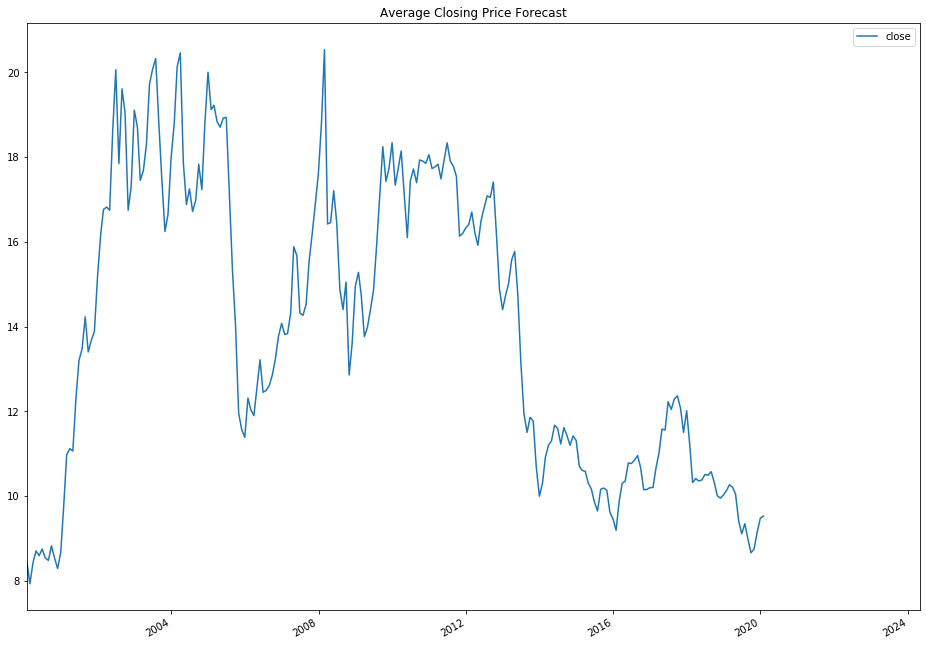

In [41]:
dfm_full['forecast'] = res.get_forecast(steps=50) #res.predict(start=240, end= 300, dynamic= True) 

dfm_full[['close', 'forecast']].plot(figsize=(16, 12), title='Average Closing Price Forecast'); 

plt.plot(x_label='year')

In [42]:
dfm_full.head()

,close,forecast
2000-01-31,8.443364,<statsmodels.tsa.statespace.mlemodel.Predictio...
2000-02-29,7.931450,<statsmodels.tsa.statespace.mlemodel.Predictio...
2000-03-31,8.429478,<statsmodels.tsa.statespace.mlemodel.Predictio...
2000-04-30,8.707368,<statsmodels.tsa.statespace.mlemodel.Predictio...
2000-05-31,8.593955,<statsmodels.tsa.statespace.mlemodel.Predictio...


In [40]:
#dfm_full.iloc[240:275]

In [43]:
res.forecast(steps=50)

2020-02-29    9.688532
2020-03-31    9.735102
2020-04-30    9.844295
2020-05-31    9.640361
2020-06-30    9.476180
2020-07-31    9.138935
2020-08-31    9.203220
2020-09-30    9.298627
2020-10-31    8.920688
2020-11-30    8.814554
2020-12-31    9.135985
2021-01-31    9.062439
2021-02-28    9.287262
2021-03-31    9.141218
2021-04-30    9.047248
2021-05-31    9.367331
2021-06-30    9.513851
2021-07-31    9.365475
2021-08-31    9.356902
2021-09-30    9.280919
2021-10-31    8.687266
2021-11-30    8.727296
2021-12-31    9.010188
2022-01-31    9.081098
2022-02-28    9.272083
2022-03-31    9.278118
2022-04-30    9.348882
2022-05-31    9.244067
2022-06-30    9.138656
2022-07-31    8.837136
2022-08-31    8.887640
2022-09-30    8.950628
2022-10-31    8.531886
2022-11-30    8.453400
2022-12-31    8.767541
2023-01-31    8.721319
2023-02-28    8.939741
2023-03-31    8.822464
2023-04-30    8.759654
2023-05-31    8.999366
2023-06-30    9.098233
2023-07-31    8.920889
2023-08-31    8.923490
2023-09-30 

In [ ]:
r